In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# Hungarian

In [2]:
df = pd.read_csv('Hungarian_3.txt')
df

,driver1,driver2,driver3
0,2,5,7
1,4,2,1
2,2,6,5


In [3]:
# ones matrix for finding number of linearly independent zeros
ones_matrix = np.ones(df.shape)
print(ones_matrix)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


## 1th stage

In each row, we subtract the minimum value from all the values in that row.

In [4]:
def minRow(df, matrix):
  df = df.sub(df.min(axis=1), axis=0)

  # zero_indexes is Boolean matrix
  zero_indexes = (df == 0)

  matrix[zero_indexes.values] = 0

  return df, matrix

In [5]:
df, ones_matrix = minRow(df, ones_matrix)

In [6]:
df

,driver1,driver2,driver3
0,0,3,5
1,3,1,0
2,0,4,3


In [7]:
print(ones_matrix)

[[0. 1. 1.]
 [1. 1. 0.]
 [0. 1. 1.]]


## 2th stage

In the new resulting table, we subtract the minimum value of each column from the same column.

In [8]:
def minCol(df, matrix):
  for col in df.columns:
      if not (df[col] == 0).any():
          df[col] = df[col] - df[col].min()

  zero_indexes = (df == 0)

  matrix[zero_indexes.values] = 0

  return df, matrix

In [9]:
df, ones_matrix = minCol(df, ones_matrix)

In [10]:
df

,driver1,driver2,driver3
0,0,2,5
1,3,0,0
2,0,3,3


In [11]:
print(ones_matrix)

[[0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 1.]]


## 3th stage

covering the obtained zeros with the least horizontal and vertical lines.

In [12]:
# Covering zeros by using index of matrix on dataframe
def Covered_P(new_matrix):

  k = 0
  n, m = new_matrix.shape
  maximum = max(n, m)

  while np.any(new_matrix == 0) and k != maximum:
    # number of zeros in each rows and columns
    zero_counts = np.sum(new_matrix == 0, axis=0)
    zero_counts2 = np.sum(new_matrix == 0, axis=1)

    # find max zeros for choice
    max_row = np.max(zero_counts2)
    max_col = np.max(zero_counts)



    if max_row >= max_col:
      for i in range(len(zero_counts2)):
        if zero_counts2[i] == max_row:
          for j in range(len(zero_counts)):
            if new_matrix[i, j] == 0:
              new_matrix[i, j] = 0.1
            elif new_matrix[i, j] == 1:
              new_matrix[i, j] = 2

    if max_row < max_col:
      for i in range(len(zero_counts)):
        if zero_counts[i] == max_col:
          for j in range(len(zero_counts2)):
            if new_matrix[j, i] == 0:
              new_matrix[j, i] = 0.1
            if new_matrix[j, i] == 1:
              new_matrix[j, i] = 2

    k += 1

  return new_matrix, k

In [13]:
new_matrix, k = Covered_P(ones_matrix)

In [14]:
print(new_matrix)

[[0.1 1.  1. ]
 [2.  0.1 0.1]
 [0.1 1.  1. ]]


In [15]:
def Display_L(df, new_matrix):
  indices = np.where((new_matrix == 0.1) | (new_matrix == 2))
  rows, cols = indices

  plt.figure(figsize=(8,6))

  sns.heatmap(df, annot=True, fmt=".2f", cmap='viridis', cbar=True)

  plt.scatter(cols + 0.5, rows + 0.5, s=100, color='red', marker='o', label='Covered points')

  points = set(zip(rows, cols))

  for r, c in points:
      if (r, c+1) in points:
          plt.plot([c+0.5, c+1+0.5], [r+0.5, r+0.5], color='red', linewidth=2)
      if (r+1, c) in points:
          plt.plot([c+0.5, c+0.5], [r+0.5, r+1+0.5], color='red', linewidth=2)

  plt.legend(loc='upper right')
  plt.title("Covering choosen points")
  plt.show()

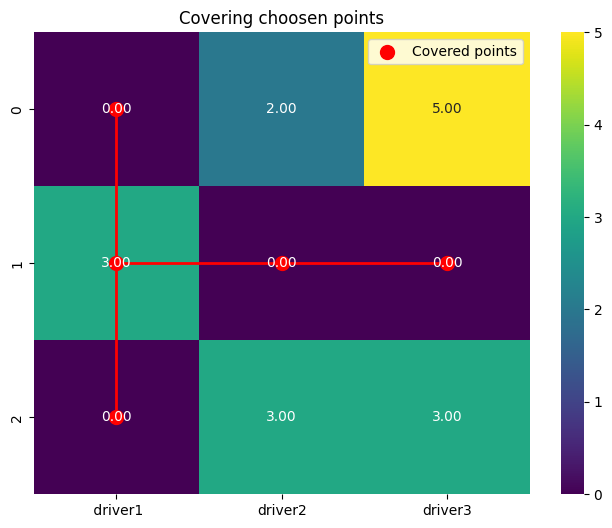

In [16]:
Display_L(df, new_matrix)

In [17]:
print(new_matrix)

[[0.1 1.  1. ]
 [2.  0.1 0.1]
 [0.1 1.  1. ]]


In [18]:
df

,driver1,driver2,driver3
0,0,2,5
1,3,0,0
2,0,3,3


## 4th stage

If the number of lines is equal to the number of rows or columns, we can get the optimal solution, otherwise, we subtract the minimum uncovered points from all uncovered points and cover the zeros again. (We repeat this until the number of lines is equal to the number of rows or columns.)

In [19]:
def min_Remaining(df, new_matrix, k):
  n, m = new_matrix.shape
  maximum = max(n, m)

  if k >= maximum:
    return f'its covered, no need to new computing !!!'

  else:
    # minimum computing on uncovered points
    while k < maximum:

      indices = np.argwhere(new_matrix == 1)

      values = [df.iat[i, j] for i, j in indices]

      min_val = min(values)

      for i, j in indices:
          df.iat[i, j] -= min_val


      # Covering choosen points again ...

      zero_indexes = (df == 0)

      mask = zero_indexes & (new_matrix != 0.1)

      new_matrix[mask.values] = 0

      zero_counts = np.sum(new_matrix == 0, axis=0)
      zero_counts2 = np.sum(new_matrix == 0, axis=1)


      max_row = np.max(zero_counts2)
      max_col = np.max(zero_counts)


      if max_row <= max_col:
        for i in range(len(zero_counts)):
          if zero_counts[i] == max_col:
            for j in range(len(zero_counts2)):
              if new_matrix[j, i] == 0:
                new_matrix[j, i] = 0.1
              if new_matrix[j, i] == 1:
                new_matrix[j, i] = 2

      if max_row > max_col:
        for i in range(len(zero_counts2)):
          if zero_counts2[i] == max_row:
            for j in range(len(zero_counts)):
              if new_matrix[i, j] == 0:
                new_matrix[i, j] = 0.1
              elif new_matrix[i, j] == 1:
                new_matrix[i, j] = 2

      k += 1

      Display_L(df, new_matrix)

  return df, new_matrix

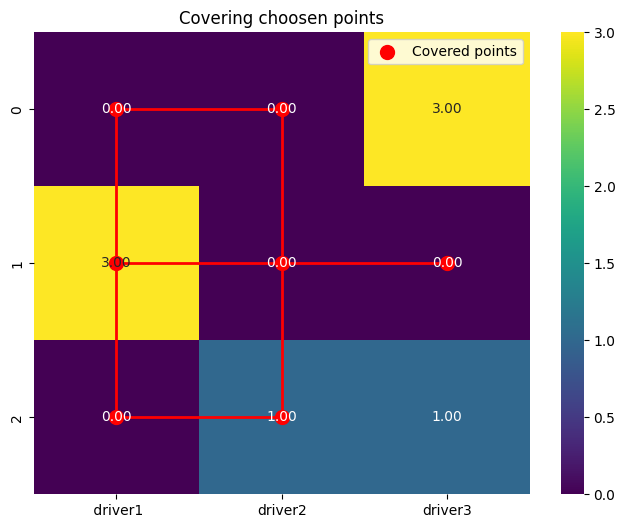

In [20]:
df, new_matrix = min_Remaining(df, new_matrix, k)

In [21]:
df

,driver1,driver2,driver3
0,0,0,3
1,3,0,0
2,0,1,1


In [22]:
print(new_matrix)

[[0.1 0.1 1. ]
 [2.  0.1 0.1]
 [0.1 2.  1. ]]


## 5th stage

We keep only linearly independent zeros.

In [29]:
binary_matrix = (new_matrix == 0.1).astype(int)
print(binary_matrix)

[[1 1 0]
 [0 1 1]
 [1 0 0]]


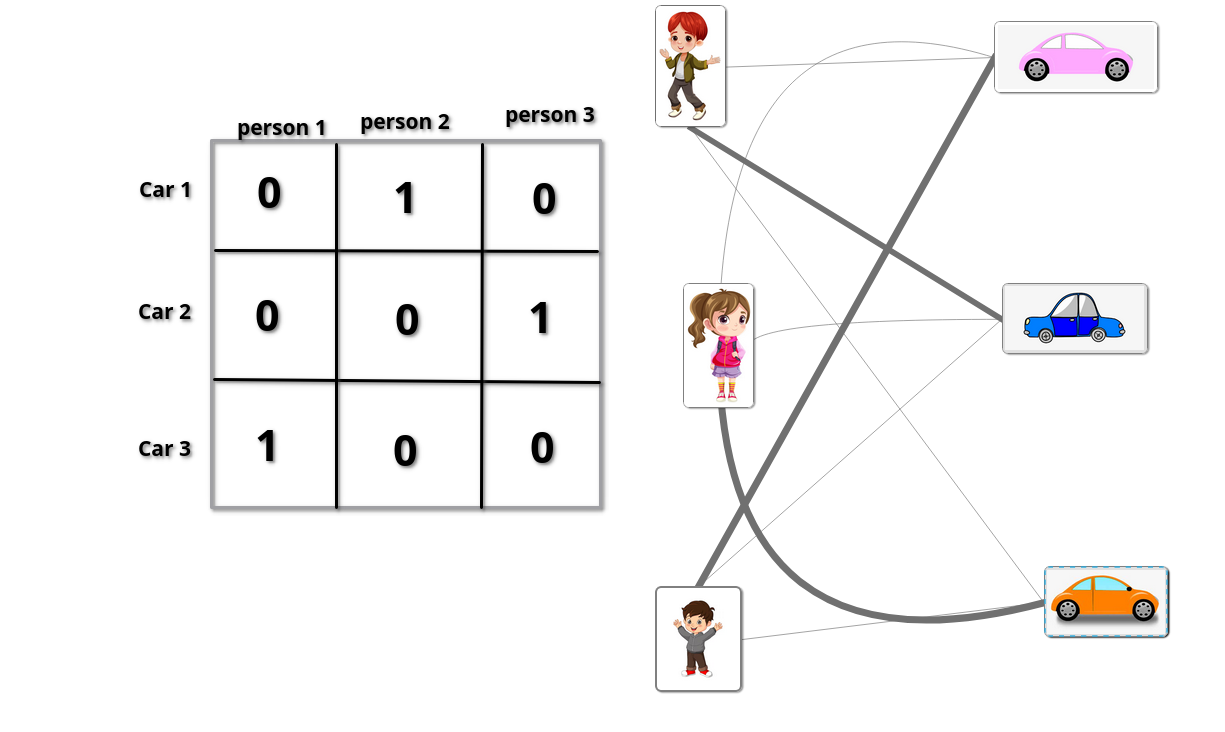